In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline

from vision.utils.box_utils import pseudo_sigmoid, get_sigmoid_mask, iou_of
from vision.utils.box_utils import assign_priors_for_sigmoid_masking

In [5]:
img_size = 300
gt_boxes = torch.Tensor([
                        [0.3,0.3,0.6,0.6],
                        [0.1,0.1,0.3,0.3],
                        [0.8,0.7,0.9,0.8]
                        ])
gt_labels = torch.Tensor([4, 5, 6])
iou_threshold = 0.5

In [16]:
alpha = 0.4
beta = 0.6

# size: num_priors * num_targets [8732, num_targets]
ious = iou_of(gt_boxes.unsqueeze(0), corner_priors.unsqueeze(1)) # [8732, num_targets]各gt,dafaultboxのIoU
best_target_per_prior, best_target_per_prior_index = ious.max(1)
best_prior_per_target, best_prior_per_target_index = ious.max(0)

for target_index, prior_index in enumerate(best_prior_per_target_index): # this prior is the best for each object. 
    best_target_per_prior_index[prior_index] = target_index

# 2.0 is used to make sure every target has [at least] one prior assigned
# even if the iou < iou_threshold, prior is assigned

best_target_per_prior.index_fill_(0, best_prior_per_target_index, 2) # 選ばれたpriorはiouを高くしておく（２）
labels = gt_labels[best_target_per_prior_index]

iou_sigmoid_mask = get_sigmoid_mask(best_target_per_prior, alpha, beta, alpha_y=0.01)

# before this
labels[best_target_per_prior < alpha] = 0 # IoU以下のpriorはバックグラウンドクラスにする
boxes = gt_boxes[best_target_per_prior_index]

# boxes: memorize anchor's place of gt that each anchor is the most near to.
# labels: memorize label index of the gt_box which is the most near to, in each anchor.

In [17]:
iou_sigmoid_mask[iou_sigmoid_mask > 0.3]

tensor([0.4986, 0.4986, 0.4986, 0.4986, 0.4986, 0.4986, 0.4986, 0.4986, 0.4986,
        0.9898, 0.4971, 0.7394, 0.8944, 0.8097, 0.4971, 0.7394, 0.7394, 1.0000,
        0.4971, 0.8944, 0.8944, 0.9898, 0.4971, 0.8944, 0.7394, 1.0000, 0.8652,
        0.8958, 0.8958, 0.9878, 0.7513, 0.8958, 0.3373, 0.9878, 0.7513, 0.3373,
        0.8958, 0.5942, 0.3373, 0.3373, 0.6587, 1.0000, 0.4160, 1.0000, 1.0000,
        1.0000, 0.4160, 1.0000, 0.7026, 0.4556, 0.7026, 0.4556, 1.0000, 0.4556,
        0.4556])

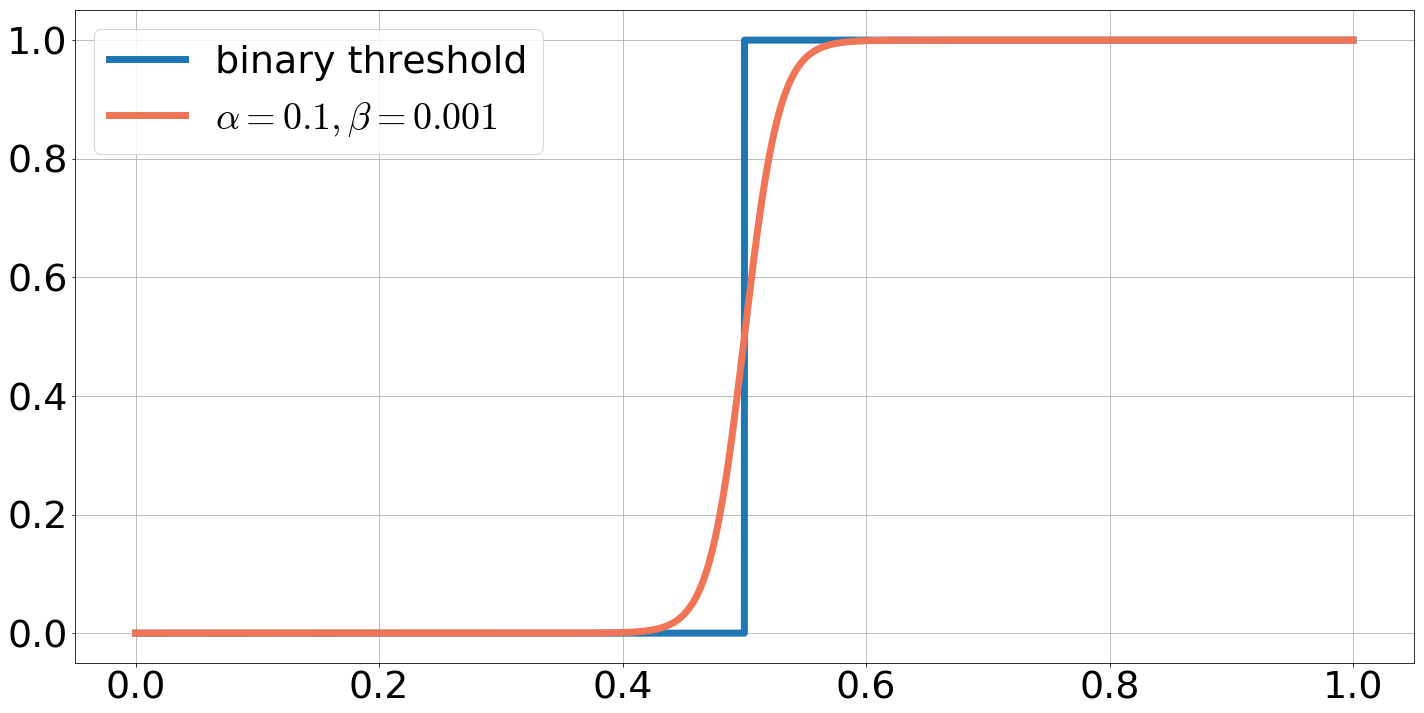

In [15]:
alpha = 0.4
beta = 0.6
alpha_y = 0.001

plt.rcParams["font.size"] = 38
plt.figure(figsize=(24,12))
plt.rcParams['font.family'] = "Arial"
plt.rcParams["mathtext.fontset"] = "cm"
plt.plot(x.numpy(), y.numpy(), linewidth=7, label="binary threshold")
for alpha_y, c in zip([0.001], ["#F07456", "#DF9F56", "#7A3EC5", "#49CD4D", "#D598BA"]):
    x = torch.arange(0,1, 0.0001)
    out = pseudo_sigmoid(x, alpha, beta, alpha_y)
    y = x.clone()
    y[x>0.5] = 1
    y[x<=0.5] = 0    
    plt.plot(x.numpy(), out.numpy(), linewidth=7, color=c, label=r"$\alpha={}, \beta={}$".format(0.1, alpha_y))

plt.grid()
plt.legend()
# plt.show()

plt.savefig("sigmoid_threshoold.png")

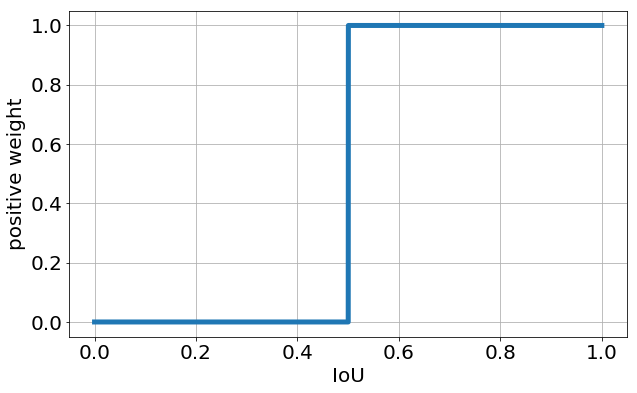

In [22]:

x = torch.arange(0,1, 0.0001)
x[x>0.5] = 1
x[x<=0.5] = 0

y = x.clone()
x = torch.arange(0,1, 0.0001)

plt.rcParams["font.size"] = 20
plt.figure(figsize=(10,6))
plt.plot(x.numpy(), y.numpy(), linewidth=5)
# plt.hlines(0.5, 0, 1, "g", linestyle="dashed", linewidth=5)
# plt.vlines(alpha, 0, 1, "r")
# plt.vlines(beta, 0, 1, "b")
plt.xlabel("IoU")
plt.ylabel("positive weight")
plt.grid()
plt.savefig("sigmoid_threshoold.png")

In [73]:
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR
import torch.optim as optim
from torchvision import models
net1 = models.vgg11()
net2 = models.resnet50()

params = [
    {"params": net1.features.parameters(), "lr":0.01},
    {"params": net2.layer3.parameters(), "lr":0.5}
]

optimizer = optim.Adagrad(params)
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=200)


In [74]:
A,B = list(), list()

for i in range(200):
    scheduler.step()
    a, b = scheduler.get_lr()
    A.append(a)
    B.append(b)
#     print(scheduler.get_lr())
    